# Use the gpio.ipynb from lab as a starting point. Add a C++ function to reset all the GPIO pins on the chosen PMOD. I will use PMODA for Assignment1

In [1]:
# Interacting with GPIO from MicroBlaze (PMODA)
from pynq.overlays.base import BaseOverlay
import time
from datetime import datetime

base = BaseOverlay("base.bit")

In [2]:
%%microblaze base.PMODA

#include "gpio.h"
#include "pyprintf.h"

void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
        return;
    }
    gpio g = gpio_open(pin);
    gpio_set_direction(g, GPIO_OUT);
    gpio_write(g, val);
}

unsigned int read_gpio(unsigned int pin){
    gpio g = gpio_open(pin);
    gpio_set_direction(g, GPIO_IN);
    return gpio_read(g);
}

void reset_all_gpios_hiz(){
    for (unsigned int pin = 0; pin < 8; ++pin){
        gpio g = gpio_open(pin);
        gpio_set_direction(g, GPIO_OUT);
        gpio_write(g, 0);
        gpio_set_direction(g, GPIO_IN);
    }
}

In [3]:
reset_all_gpios_hiz()

write_gpio(0, 1)

v = read_gpio(1)
print(v)

0


# Write a Python3 cell that emulates a PWM (for a chosen frequency and duty cycle) on one of the PMOD GPIO pins. For example, PMODA PIN3 needs to turn on for duty_cycle percent of the square wave frequency and off for the rest of the square wave. It may not be possible to achieve exactly 0% or 100% so be sure to add necessary code for those corner cases.

In [4]:
# Python3 PWM emulation on a PMOD GPIO pin via MicroBlaze (PYNQ)
from pynq.overlays.base import BaseOverlay

base = BaseOverlay("base.bit")

In [5]:
%%microblaze base.PMODA

#include "gpio.h"
#include "pyprintf.h"

void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
        return;
    }
    gpio g = gpio_open(pin);
    gpio_set_direction(g, GPIO_OUT);
    gpio_write(g, val);
}

unsigned int read_gpio(unsigned int pin){
    gpio g = gpio_open(pin);
    gpio_set_direction(g, GPIO_IN);
    return gpio_read(g);
}

void reset_all_gpios_hiz(){
    for (unsigned int pin = 0; pin < 8; ++pin){
        gpio g = gpio_open(pin);
        gpio_set_direction(g, GPIO_OUT);
        gpio_write(g, 0);
        gpio_set_direction(g, GPIO_IN);
    }
}

In [6]:
import time

def pwm_software_pmoda(
    pin,
    freq_hz,
    duty_cycle_percent,
    duration_s
):
    if freq_hz <= 0:
        raise ValueError("Frequency must be > 0")

    # Clamp duty cycle
    dc = max(0.0, min(100.0, float(duty_cycle_percent)))

    # Corner cases
    if dc <= 0.0:
        write_gpio(pin, 0)
        time.sleep(duration_s)
        return

    if dc >= 100.0:
        write_gpio(pin, 1)
        time.sleep(duration_s)
        return

    period = 1.0 / freq_hz
    t_on = period * (dc / 100.0)
    t_off = period - t_on

    MIN_SLICE = 1e-4
    t_on = max(t_on, MIN_SLICE)
    t_off = max(t_off, MIN_SLICE)

    end_time = time.perf_counter() + duration_s

    while time.perf_counter() < end_time:
        write_gpio(pin, 1)
        time.sleep(t_on)
        write_gpio(pin, 0)
        time.sleep(t_off)

    # Leave pin low at end
    write_gpio(pin, 0)

In [7]:
# Reset PMODA to a safe state
reset_all_gpios_hiz()

# Example PWM on PMODA PIN3
pwm_software_pmoda(
    pin=3,
    freq_hz=200,           # 200 Hz
    duty_cycle_percent=25, # 25% duty cycle
    duration_s=3.0         # run for 3 seconds
)

# Implementation to satisfy steps (3-6)

In [8]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

In [9]:
%%microblaze base.PMODA

#include "gpio.h"

static gpio g_r, g_g, g_b;
static int initialized = 0;

/*
Wiring (per your confirmed assignment):
  R = PMODA pin 3
  G = PMODA pin 2
  B = PMODA pin 1
*/

void init_rgb(){
    if (initialized) return;

    g_r = gpio_open(3);
    gpio_set_direction(g_r, GPIO_OUT);
    gpio_write(g_r, 0);

    g_g = gpio_open(2);
    gpio_set_direction(g_g, GPIO_OUT);
    gpio_write(g_g, 0);

    g_b = gpio_open(1);
    gpio_set_direction(g_b, GPIO_OUT);
    gpio_write(g_b, 0);

    initialized = 1;
}

void set_rgb(unsigned int r, unsigned int g, unsigned int b){
    if (!initialized) init_rgb();
    gpio_write(g_r, r ? 1 : 0);
    gpio_write(g_g, g ? 1 : 0);
    gpio_write(g_b, b ? 1 : 0);
}

void all_off(){
    if (!initialized) init_rgb();
    gpio_write(g_r, 0);
    gpio_write(g_g, 0);
    gpio_write(g_b, 0);
}

In [10]:
# Simple script to test Actuator
import time

init_rgb()

print("Actuator proof: flashing R, G, B...")
set_rgb(1, 0, 0); time.sleep(0.7)
set_rgb(0, 1, 0); time.sleep(0.7)
set_rgb(0, 0, 1); time.sleep(0.7)
all_off()

Actuator proof: flashing R, G, B...


In [11]:
PWM_FREQ = 200.0
print("Using PWM_FREQ =", PWM_FREQ, "Hz")

Using PWM_FREQ = 200.0 Hz


In [12]:
import math

def duty_for_perceived(brightness_frac: float, gamma: float = 2.2) -> float:
    b = max(0.0, min(1.0, float(brightness_frac)))
    if b <= 0.0: return 0.0
    if b >= 1.0: return 100.0
    return 100.0 * (b ** (1.0 / gamma))

targets = [1.00, 0.75, 0.50, 0.25]
duties = [duty_for_perceived(b, gamma=2.2) for b in targets]

for b, d in zip(targets, duties):
    print(f"Perceived {int(100*b):>3d}% -> duty ~ {d:5.1f}%")

Perceived 100% -> duty ~ 100.0%
Perceived  75% -> duty ~  87.7%
Perceived  50% -> duty ~  73.0%
Perceived  25% -> duty ~  53.3%


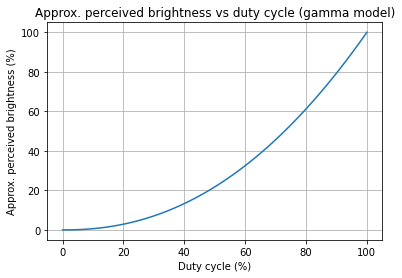

In [13]:
import matplotlib.pyplot as plt

def perceived_from_duty(duty_percent: float, gamma: float = 2.2) -> float:
    d = max(0.0, min(100.0, float(duty_percent))) / 100.0
    return 100.0 * (d ** gamma)

duty_vals = list(range(0, 101))
brightness_vals = [perceived_from_duty(d, gamma=2.2) for d in duty_vals]

plt.figure()
plt.plot(duty_vals, brightness_vals)
plt.xlabel("Duty cycle (%)")
plt.ylabel("Approx. perceived brightness (%)")
plt.title("Approx. perceived brightness vs duty cycle (gamma model)")
plt.grid(True)
plt.show()

In [14]:
import asyncio
import time
import nest_asyncio

nest_asyncio.apply()

PWM_FREQ = 200.0
FIXED_DUTY = 25.0

def _rgb_for_index(i: int):
    # 0=R, 1=G, 2=B
    if i == 0:
        return (1, 0, 0)
    if i == 1:
        return (0, 1, 0)
    return (0, 0, 1)

async def run_demo():
    init_rgb()
    all_off()

    # Shared state
    state = {
        "color_index": 0,
        "stop": False,
        "color_changed": False,
    }

    # Serialize *all* LED writes
    led_lock = asyncio.Lock()

    async def led_set_color(index: int):
        r, g, b = _rgb_for_index(int(index))
        async with led_lock:
            set_rgb(r, g, b)

    async def led_off():
        async with led_lock:
            all_off()

    async def pwm_run_for(duration_s: float):
        """
        Runs PWM for duration_s using the current state['color_index'].
        Uses lock-protected LED writes to prevent races.
        """
        dc = float(FIXED_DUTY)
        dc = max(0.0, min(100.0, dc))

        # Corner cases
        if dc <= 0.0:
            await led_off()
            await asyncio.sleep(duration_s)
            return
        if dc >= 100.0:
            await led_set_color(state["color_index"])
            await asyncio.sleep(duration_s)
            return

        period = 1.0 / float(PWM_FREQ)
        t_on = period * (dc / 100.0)
        t_off = period - t_on

        MIN_SLICE = 1e-4
        t_on = max(t_on, MIN_SLICE)
        t_off = max(t_off, MIN_SLICE)

        end_t = time.perf_counter() + duration_s
        while time.perf_counter() < end_t and not state["stop"]:
            await led_set_color(state["color_index"])
            await asyncio.sleep(t_on)
            await led_off()
            await asyncio.sleep(t_off)

    async def blinker():
        print("Blinker started.")

        # Startup indicator (solid RED briefly)
        await led_set_color(0)
        await asyncio.sleep(0.3)
        await led_off()

        while not state["stop"]:
            # If a color change occurred, commit it visibly for a short time.
            # This prevents “it changed but I couldn’t see it” at 25% duty.
            if state["color_changed"]:
                state["color_changed"] = False
                await led_set_color(state["color_index"])
                await asyncio.sleep(0.25)
                await led_off()

            # 1 second ON with PWM at fixed duty
            await pwm_run_for(1.0)

            # 1 second OFF
            await led_off()
            await asyncio.sleep(1.0)

        await led_off()
        print("Blinker stopped.")

    async def buttons():
        print("Buttons task started.")
        idle = [int(base.buttons[i].read()) for i in range(4)]
        prev = idle[:]
        print("Button idle levels:", idle, "(press = transition away from idle)")

        while not state["stop"]:
            cur = [int(base.buttons[i].read()) for i in range(4)]

            for i in range(4):
                # Edge: transition away from idle
                if cur[i] != idle[i] and prev[i] == idle[i]:
                    if i in (0, 1, 2):
                        state["color_index"] = i
                        state["color_changed"] = True
                        print(f"Button {i} -> Color = {['RED','GREEN','BLUE'][i]}")
                    elif i == 3:
                        print("Button 3 -> STOP")
                        state["stop"] = True

            prev = cur
            await asyncio.sleep(0.02)

        print("Buttons task stopped.")

    print("Demo: 1s ON / 1s OFF blink; duty fixed at 25%. Buttons 0/1/2 select RGB; 3 stops.")
    await asyncio.gather(blinker(), buttons())

asyncio.get_event_loop().run_until_complete(run_demo())

Demo: 1s ON / 1s OFF blink; duty fixed at 25%. Buttons 0/1/2 select RGB; 3 stops.
Blinker started.
Buttons task started.
Button idle levels: [0, 0, 0, 0] (press = transition away from idle)
Button 0 -> Color = RED
Button 1 -> Color = GREEN
Button 2 -> Color = BLUE
Button 3 -> STOP
Buttons task stopped.
Blinker stopped.
